# This notebook is to explore adding cdc features to reporter and determine the effect in performance

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
from src.models.baseline_ML_functions import common_name_to_genus_speices
from src.models.NN_functions import *
from src.ensemble.ensemble_functions import get_strain_mapping_short, plot_stage2_aggregated_accuracy
from sklearn.preprocessing import MinMaxScaler
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-02-14 20:55:06.469360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# embedded CDC features obtained from the "CDC_features_embedding1.ipynb" notebook
post_train_mean = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv', index_col = 0)
scaler = MinMaxScaler()
post_train_mean.iloc[:,:] = scaler.fit_transform(post_train_mean.iloc[:,:])

In [3]:
all_IVV_df = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/NN_all_IVV.csv')
all_IVV_df = all_IVV_df.groupby(['Common Name']).sample(400).reset_index(drop = True)
name_mapping = common_name_to_genus_speices()
all_IVV_df['genus_species'] = all_IVV_df['Common Name'].map(name_mapping)

In [4]:
ivv_w_cdc_joined = pd.merge(all_IVV_df, post_train_mean, left_on = 'genus_species', right_index = True)

In [5]:
# take two IVV strains as the controls (since ivv_w_cdc_joinedthey match to the CDC instances so could add the CDC features to the model)
new_controls = ivv_w_cdc_joined[ivv_w_cdc_joined['Common Name'].isin(['NIST0012','NIST0027'])]
new_test = ivv_w_cdc_joined[~ivv_w_cdc_joined['Common Name'].isin(['NIST0012','NIST0027'])]

# Test using the reporter features alone

In [7]:
feature_cols1 = [col for col in new_controls if 'scaled' in col]
reporter_test, acc_df1 = sweep_NN_w_entropy(new_controls, new_test, feature_cols1, 
                                           adjusted_bce_n_entropy_loss(0,1), y_cols = ['Foe', 'org_index'], 
                                           percents = [0.3,0.4,0.5,0.6,0.7], repeat = 5, 
                                           output_dir = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter', output_name = 'reporter_no_cdc_test.csv')

100/100 [==============================] - 0s 2ms/step
the test data has been saved


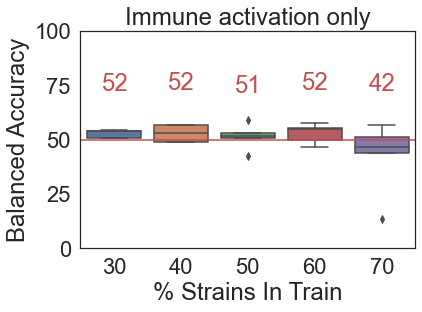

In [43]:
plot_sweep_nn_accuracy(acc_df1, f'Immune activation only', print_acc = True)

# Test using the reporter features + CDC features (aggregated with simple averaging, not embedding)

In [8]:
# binary features
cdc_features = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/processed_cdc_data.csv', index_col = 0)

In [9]:
def join_reporter_w_cdc(cdc_df, reporter_df):
    '''A method to join cdc df and reporter df based on shared genus + species names'''
    reporter_small = reporter_df.groupby(['Common Name']).sample(400).reset_index(drop = True)
    name_mapping = common_name_to_genus_speices()
    reporter_small['genus_species'] = reporter_small['Common Name'].map(name_mapping)
    scaler = MinMaxScaler()
    cdc_df['instance_sum'] = scaler.fit_transform(
        cdc_df['instance_sum'].values.reshape(len(cdc_df),1))
    IVV_w_cdc = pd.merge(reporter_small, cdc_df, left_on = 'genus_species', right_index = True)
    return IVV_w_cdc

In [10]:
ivv_w_cdc_joined1 = pd.merge(all_IVV_df, cdc_features, left_on = 'genus_species', right_index = True)

In [11]:
# take two IVV strains as the controls (since they match to the CDC instances so could add the CDC features to the model)
new_controls2 = ivv_w_cdc_joined1[ivv_w_cdc_joined1['Common Name'].isin(['NIST0012','NIST0027'])]
new_test2 = ivv_w_cdc_joined1[~ivv_w_cdc_joined1['Common Name'].isin(['NIST0012','NIST0027'])]
feature_cols2 = feature_cols1 + cdc_features.columns.to_list()

In [22]:
# use the same shift and weight as the SBRL embedding below (apple to apple comparison)
reporter_emb_test, acc_df = sweep_NN_w_entropy(new_controls2, new_test2, feature_cols2, 
                                               adjusted_bce_n_entropy_loss(0.15, 1), y_cols = ['Foe', 'org_index'], 
                                               percents = [0.3,0.4,0.5,0.6,0.7], repeat = 5,
                                               output_dir = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter', 
                                               output_name = 'reporter_cdc_features_test.csv')

the test data has been saved


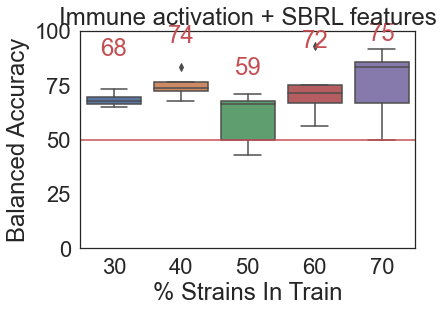

In [31]:
plot_sweep_nn_accuracy(acc_df, f'Immune activation + SBRL features', print_acc= True)

# Test using the reporter features + CDC embedding

In [7]:
feature_cols3 = feature_cols1 + post_train_mean.columns.tolist()
reporter_emb_test, acc_df = sweep_NN_w_entropy(new_controls, new_test, feature_cols3, 
                            adjusted_bce_n_entropy_loss(0.15, 1), y_cols = ['Foe', 'org_index'], 
                                               percents = [0.3,0.4,0.5,0.6,0.7], repeat = 5,
                                               output_dir = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter', 
                                               output_name = 'reporter_w_CDC_emb_test.csv')

the test data has been saved


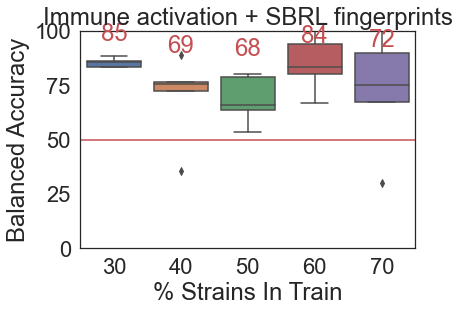

In [51]:
plot_sweep_nn_accuracy(acc_df, f'Immune activation + SBRL fingerprints', print_acc = True)